# LDA

Let's reproduce the LDA method used in the paper:

Plecháč, P.; Haider, T. (2020) ‘Mapping Topic Evolution Across Poetic Traditions’.  <https://arxiv.org/abs/2006.15732> accessed 1 April 2024

In [1]:
import pandas as pd
from ast import literal_eval
from langdetect import detect
import gensim

In [2]:
pd.set_option('display.max_columns', None)

# Load the data
- data are in the format of 1 poem per row

In [3]:
# load smaller random x% fraction
books = pd.read_csv('../data/books_frac_0.2.csv', low_memory=False)

# Repair data
- some of the years are encapsulated in list, e.g. [1785] - cast them into integers

In [4]:
years = []

for index, poem in books.iterrows():
    try:
        years.append(int(poem['biblio.year']))
    except:
        if poem['biblio.year'] == 'neuveden':
            years.append('unknown')
        else:
            years.append(literal_eval(poem['biblio.year'])[0])

books['biblio.year'] = years

# Remove duplicates - remain just the first edition (and its equivalents)

In [5]:
books.shape

(13286, 24)

In [6]:
books.head()

,book_id,poem_id,body,p_author.born,p_author.died,p_author.name,p_author.identity,biblio.motto_aut,biblio.b_subtitle,biblio.publisher,biblio.edition,biblio.motto,biblio.p_title,biblio.place,biblio.dedication,biblio.b_title,biblio.pages,biblio.year,biblio.signature,b_author.born,b_author.died,b_author.name,b_author.identity,results.poem
0,623,0001-0004-0000-0008-0000,"[[{'text': 'Je-li v domě hezká dcera, ', 'punc...",1842.0,1924.0,"Martinec, Jaroslav","Martinec, Jaroslav",NaN,NaN,"Grégr, Eduard; Dattel, Ferdinand",[1.],NaN,"Je-li v domě hezká dcera,",Praha,NaN,Básně,102,1872,ÚČL AV ČR; 849 VIII 1,1842.0,1924.0,"Martinec, Jaroslav","Martinec, Jaroslav",NaN
1,638,0001-0001-0000-0167-0000,"[[{'text': 'Z obchodu nekalého, špinavého vytě...",1857.0,1909.0,"Menhard Litoměřický, Xaver","Menhard, František Ladislav",NaN,Nevázané řeči ve vázané řeči,"Knapp, Mamert",[1.],NaN,Také „čistý“ výtěžek.,Praha,NaN,Divoké ovoce,176,1892,"Národní knihovna ČR, Praha; 54 K 622",1857.0,1909.0,"Menhard Litoměřický, Xaver","Menhard, František Ladislav",NaN
2,281,0001-0000-0000-0004-0004,"[[{'text': 'Hle! na jezeru hvězdném', 'punct':...",1813.0,1881.0,"Jablonský, Boleslav","Jablonský, Boleslav",NaN,NaN,"Spurný, Jan",[1.],NaN,Lásky boj. (IV. Milosti plod.),Praha,NaN,Básně,190,1841,ÚČL AV ČR; Staré tisky 111,1813.0,1881.0,"Jablonský, Boleslav","Jablonský, Boleslav",NaN
3,1283,0001-0000-0000-0013-0000,[[{'text': 'Král Louis vyjel na lov s družinou...,1883.0,1919.0,"Hašek, Roman","Hašek, Roman",NaN,1902-1903,"Popelka, Václav",[1.],NaN,STARÁ POHÁDKA.,Týn nad Vltavou,NaN,Pohádka zelených očí a verše o stesku i výsměchu,96,1904,ÚČL AV ČR; P 515,1883.0,1919.0,"Hašek, Roman","Hašek, Roman",NaN
4,395,0001-0004-0000-0009-0000,[[{'text': 'Blíž cesty za městem vůz loutkářův...,1866.0,1938.0,"Klášterský, Antonín","Klášterský, Antonín",NaN,Básně,"Šimáček, František; Kabinetní knihovna",[1.],NaN,DNES SE NEHRAJE.,Praha,NaN,Srdce i duše,188,1894,ÚČL AV ČR; P 341,1866.0,1938.0,"Klášterský, Antonín","Klášterský, Antonín",NaN


In [7]:
books['biblio.edition'].value_counts()

[1.]                                                10074
1.                                                   2049
3.                                                    242
2.                                                    219
[3., s tímto titulem 2.]  (Úpelné vydání.)            134
[2.]                                                   97
7.                                                     77
[1. v tomto svazku]                                    73
5.                                                     71
4.                                                     68
I.                                                     44
9.                                                     34
2., rozmnožené vydání                                  23
2. [s tímto titulem 1.]                                22
8.                                                     21
3. (Sny o štěstí) a 4. (Vittoria Colonna)              13
[2. v této podobě]                                     10
14., nezměněné

In [8]:
editions_to_keep = ['[1.]', '1.', '[1. v tomto svazku]', '1. v tomto svazku ', '2. [s tímto titulem 1.]', '2., přepracované a rozšířené; 1. s tímto titulem', '1. v tomto svazku'] 
    
books = books[books['biblio.edition'].isin(editions_to_keep)]

In [9]:
# reduced size
books.shape

(12222, 24)

# Keep just noun, adjective and verb lemmas

- POS tag is contained in the 'morph' field.
- More info: https://ufal.mff.cuni.cz/pdt/Morphology_and_Tagging/Doc/hmptagqr.html

In [10]:
%%time
# evaluate a string columns 'body' as a json
books['body'] = books['body'].apply(lambda x: literal_eval(str(x)))

CPU times: user 2min 31s, sys: 5.32 s, total: 2min 36s
Wall time: 2min 50s


In [11]:
lemmas_col = []

for index, poem in books.iterrows():
    lemmas_poem = []
    for stanza in poem['body']:
        for line in stanza:
            for word in line['words']:
                # if POS tag is Noun, Adjective or Verb
                if word['morph'][0] in ['N', 'A', 'V']:
                    lemmas_poem.append(word['lemma'])
    lemmas_col.append(lemmas_poem)

In [12]:
books['lemmas'] = lemmas_col

In [13]:
books.head(1)

,book_id,poem_id,body,p_author.born,p_author.died,p_author.name,p_author.identity,biblio.motto_aut,biblio.b_subtitle,biblio.publisher,biblio.edition,biblio.motto,biblio.p_title,biblio.place,biblio.dedication,biblio.b_title,biblio.pages,biblio.year,biblio.signature,b_author.born,b_author.died,b_author.name,b_author.identity,results.poem,lemmas
0,623,0001-0004-0000-0008-0000,"[[{'text': 'Je-li v domě hezká dcera, ', 'punc...",1842.0,1924.0,"Martinec, Jaroslav","Martinec, Jaroslav",NaN,NaN,"Grégr, Eduard; Dattel, Ferdinand",[1.],NaN,"Je-li v domě hezká dcera,",Praha,NaN,Básně,102,1872,ÚČL AV ČR; 849 VIII 1,1842.0,1924.0,"Martinec, Jaroslav","Martinec, Jaroslav",NaN,"[být, dům, hezký, dcera, být, krám, ráno, veče..."


# Remove other languages - keep just the Czech
- although `langdetect` can detect different language than 'cs', manual check is needed
- after manual check, languages detected different from 'cs' were not proven to be so
- one error occurred - no lemmas were parsed from the poem body - it is marked as 'unknown'

In [14]:
%%time

language_col = []

for index, poem in books.iterrows():
    try:
        language = detect(' '.join(poem['lemmas']))
    except Exception as e:
        language = 'unknown'
    language_col.append(language)

books['language'] = language_col

CPU times: user 1min 5s, sys: 1.75 s, total: 1min 7s
Wall time: 1min 7s


In [15]:
books['language'].value_counts()

cs         12184
sk            26
hu             2
unknown        1
hr             1
sv             1
de             1
nl             1
da             1
no             1
sl             1
lt             1
et             1
Name: language, dtype: int64

In [16]:
books.loc[books['language'] == 'unknown']

,book_id,poem_id,body,p_author.born,p_author.died,p_author.name,p_author.identity,biblio.motto_aut,biblio.b_subtitle,biblio.publisher,biblio.edition,biblio.motto,biblio.p_title,biblio.place,biblio.dedication,biblio.b_title,biblio.pages,biblio.year,biblio.signature,b_author.born,b_author.died,b_author.name,b_author.identity,results.poem,lemmas,language
2866,174,0001-0003-0005-0018-0000,"[[{'text': 'Napřed proč? ', 'punct': {'2': '?'...",1821.0,1856.0,"Havlíček Borovský, Karel","Havlíček Borovský, Karel",NaN,NaN,"Pražák, Albert; Orbis; Bělič, Jaromír; Národní...",[1.],NaN,Napřed proč?,Praha,NaN,Básnické dílo,246,1950,ÚČL AV ČR; 52 VIII 50,1821.0,1856.0,"Havlíček Borovský, Karel","Havlíček Borovský, Karel",NaN,[],unknown


# Create BOW (bag of words)
- inspired by: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
- gensim reference: https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py

In [17]:
dictionary = gensim.corpora.Dictionary(books['lemmas'])

In [18]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 být
1 dcera
2 děvče
3 dům
4 hezký
5 hoch
6 krám
7 krásný
8 panímáma
9 ráno
10 sdílet


In [19]:
# IMPORTANT hyperparameters
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [20]:
bow_corpus = [dictionary.doc2bow(doc) for doc in books['lemmas']]

In [21]:
bow_doc_0 = bow_corpus[0]
for i in range(len(bow_doc_0)):
    print("Word {} (\"{}\") appears {} time in the particular poem.".format(bow_doc_0[i][0], dictionary[bow_doc_0[i][0]], bow_doc_0[i][1]))

Word 0 ("dcera") appears 1 time.
Word 1 ("děvče") appears 1 time.
Word 2 ("dům") appears 1 time.
Word 3 ("hezký") appears 1 time.
Word 4 ("hoch") appears 1 time.
Word 5 ("krám") appears 1 time.
Word 6 ("krásný") appears 1 time.
Word 7 ("ráno") appears 1 time.
Word 8 ("sdílet") appears 1 time.
Word 9 ("usoudit") appears 1 time.
Word 10 ("večer") appears 1 time.
Word 11 ("věno") appears 1 time.
Word 12 ("závora") appears 1 time.
Word 13 ("štědrý") appears 1 time.
Word 14 ("šťastný") appears 1 time.


# Apply LDA

In [22]:
%%time
# train a model
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=100, id2word=dictionary, passes=100, workers=3)

CPU times: user 12min 3s, sys: 28.8 s, total: 12min 32s
Wall time: 18min 33s


In [23]:
# print trained topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWord: {}'.format(idx, topic))

Topic: 0 
Word: 0.082*"chudý" + 0.024*"sedlák" + 0.021*"boháč" + 0.019*"mládež" + 0.015*"vléci" + 0.013*"úroda" + 0.013*"zjevení" + 0.013*"úkol" + 0.013*"zdravý" + 0.012*"dav"
Topic: 1 
Word: 0.213*"starý" + 0.034*"nový" + 0.021*"hlava" + 0.021*"dělník" + 0.016*"dům" + 0.012*"ruka" + 0.010*"vstát" + 0.010*"zeď" + 0.009*"dávný" + 0.009*"mladý"
Topic: 2 
Word: 0.052*"víra" + 0.048*"Kristus" + 0.048*"hřích" + 0.036*"svatý" + 0.028*"pán" + 0.023*"bůh" + 0.015*"naděje" + 0.014*"znát" + 0.014*"bývat" + 0.014*"mít"
Topic: 3 
Word: 0.039*"bůh" + 0.021*"y" + 0.019*"svět" + 0.017*"nebe" + 0.017*"otec" + 0.016*"srdce" + 0.014*"matka" + 0.013*"krása" + 0.013*"láska" + 0.012*"dítě"
Topic: 4 
Word: 0.025*"duše" + 0.022*"most" + 0.021*"padat" + 0.020*"hlas" + 0.020*"slyšet" + 0.015*"květ" + 0.014*"svítat" + 0.012*"zlatý" + 0.011*"pustit" + 0.010*"čas"
Topic: 5 
Word: 0.065*"krev" + 0.040*"mřít" + 0.025*"kus" + 0.023*"kalný" + 0.022*"vlastní" + 0.021*"odpověď" + 0.018*"boj" + 0.012*"zalkat" + 0.012*"ň

## Assign topic to the poem (classification)

In [24]:
topic_bow_col = []

for bow_poem in bow_corpus:
    try:
        # pick the most likely topic
        topic_bow_col.append(sorted(lda_model.get_document_topics(bow_poem), key=lambda tup: -1*tup[1])[0][0])
    except Exception as e:
        topic_bow_col.append('-1') # unknown
        
books['topic_bow'] = topic_bow_col

In [25]:
books.head()

,book_id,poem_id,body,p_author.born,p_author.died,p_author.name,p_author.identity,biblio.motto_aut,biblio.b_subtitle,biblio.publisher,biblio.edition,biblio.motto,biblio.p_title,biblio.place,biblio.dedication,biblio.b_title,biblio.pages,biblio.year,biblio.signature,b_author.born,b_author.died,b_author.name,b_author.identity,results.poem,lemmas,language,topic_bow
0,623,0001-0004-0000-0008-0000,"[[{'text': 'Je-li v domě hezká dcera, ', 'punc...",1842.0,1924.0,"Martinec, Jaroslav","Martinec, Jaroslav",NaN,NaN,"Grégr, Eduard; Dattel, Ferdinand",[1.],NaN,"Je-li v domě hezká dcera,",Praha,NaN,Básně,102,1872,ÚČL AV ČR; 849 VIII 1,1842.0,1924.0,"Martinec, Jaroslav","Martinec, Jaroslav",NaN,"[být, dům, hezký, dcera, být, krám, ráno, veče...",cs,75
1,638,0001-0001-0000-0167-0000,"[[{'text': 'Z obchodu nekalého, špinavého vytě...",1857.0,1909.0,"Menhard Litoměřický, Xaver","Menhard, František Ladislav",NaN,Nevázané řeči ve vázané řeči,"Knapp, Mamert",[1.],NaN,Také „čistý“ výtěžek.,Praha,NaN,Divoké ovoce,176,1892,"Národní knihovna ČR, Praha; 54 K 622",1857.0,1909.0,"Menhard Litoměřický, Xaver","Menhard, František Ladislav",NaN,"[obchod, nekalý, špinavý, vytěžit, společník, ...",cs,44
2,281,0001-0000-0000-0004-0004,"[[{'text': 'Hle! na jezeru hvězdném', 'punct':...",1813.0,1881.0,"Jablonský, Boleslav","Jablonský, Boleslav",NaN,NaN,"Spurný, Jan",[1.],NaN,Lásky boj. (IV. Milosti plod.),Praha,NaN,Básně,190,1841,ÚČL AV ČR; Staré tisky 111,1813.0,1881.0,"Jablonský, Boleslav","Jablonský, Boleslav",NaN,"[jezero, hvězdný, plující, nebesa, labuť, druž...",cs,70
3,1283,0001-0000-0000-0013-0000,[[{'text': 'Král Louis vyjel na lov s družinou...,1883.0,1919.0,"Hašek, Roman","Hašek, Roman",NaN,1902-1903,"Popelka, Václav",[1.],NaN,STARÁ POHÁDKA.,Týn nad Vltavou,NaN,Pohádka zelených očí a verše o stesku i výsměchu,96,1904,ÚČL AV ČR; P 515,1883.0,1919.0,"Hašek, Roman","Hašek, Roman",NaN,"[král, Louis, vyjet, lov, družina, oj, pokřik,...",cs,7
4,395,0001-0004-0000-0009-0000,[[{'text': 'Blíž cesty za městem vůz loutkářův...,1866.0,1938.0,"Klášterský, Antonín","Klášterský, Antonín",NaN,Básně,"Šimáček, František; Kabinetní knihovna",[1.],NaN,DNES SE NEHRAJE.,Praha,NaN,Srdce i duše,188,1894,ÚČL AV ČR; P 341,1866.0,1938.0,"Klášterský, Antonín","Klášterský, Antonín",NaN,"[cesta, město, vůz, loutkářův, stát, známý, pr...",cs,6


# Bin data according the year

In [31]:
books['biblio.year'].describe()

count     12222
unique      148
top        1897
freq        377
Name: biblio.year, dtype: int64

In [32]:
books.drop(books[books['biblio.year'] == 'unknown'].index, inplace=True)

In [33]:
# use equi-distance binning with bin size of 25 years
step = 25
bins = [i for i in range(books['biblio.year'].min(), books['biblio.year'].max()+step+1, step)]
bins

[1785, 1810, 1835, 1860, 1885, 1910, 1935, 1960, 1985]

In [34]:
books['bin'] = pd.cut(books['biblio.year'], bins)

In [35]:
books['bin'].describe()

count            12216
unique               8
top       (1885, 1910]
freq              5024
Name: bin, dtype: object

# Plot topic evolution

In [36]:
books['topic_bow'].value_counts().head(20)

79    655
30    533
70    532
26    434
97    418
17    417
61    405
7     398
85    387
11    359
38    337
94    337
72    324
35    322
18    281
96    266
44    258
80    227
82    222
93    210
Name: topic_bow, dtype: int64

In [114]:
topic = 17

In [115]:
topic_over_years = books.loc[books['topic_bow'] == topic].groupby(['bin', 'topic_bow']).size().unstack(level=1)

<AxesSubplot:xlabel='bin'>

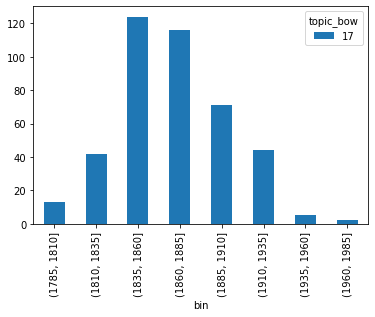

In [120]:
topic_over_years.plot(kind = 'bar')

In [121]:
lda_model.print_topic(topic)

'0.008*"slovo" + 0.007*"duch" + 0.007*"láska" + 0.007*"srdce" + 0.006*"mít" + 0.005*"mnohý" + 0.005*"mysl" + 0.005*"hlas" + 0.005*"otec" + 0.004*"čin"'

In [122]:
books['bin'].value_counts().head(20)

(1885, 1910]    5024
(1910, 1935]    2597
(1860, 1885]    2283
(1835, 1860]     898
(1935, 1960]     688
(1810, 1835]     496
(1960, 1985]     194
(1785, 1810]      36
Name: bin, dtype: int64